In [1]:
import numpy as np
from scipy import integrate
import torch
import torch.autograd as autograd
import torch.nn as nn

from pyDOE import lhs
import scipy.io
import csv
import pprint
import matplotlib.pyplot as plt
import time

In [2]:
'''初期設定'''
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda


In [3]:
gamma=1.4
rgas=8.314e+03/28.96
cvgas=rgas/(gamma-1.0)

In [4]:
'''理論解の読み込み'''

#圧力
with open('shocktube/p.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]

t = []
x = []
p_calc = []
p_exact = []
for i in range(len(l)):
    x.append(float(l[i][0]))
    t.append(float(l[i][1]))
    p_calc.append(float(l[i][2]))
    p_exact.append(float(l[i][3]))

t = np.array(t)
x = np.array(x)
p_calc = np.array(p_calc)
p_exact = np.array(p_exact)

x = x.reshape([69, 501])
t = t.reshape([69, 501])
p_exact = p_exact.reshape([69, 501])
p_calc = p_calc.reshape([69, 501])

#密度
with open('shocktube/rho.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]

rho_calc = []
rho_exact = []
for i in range(len(l)):
    rho_calc.append(float(l[i][2]))
    rho_exact.append(float(l[i][3]))

rho_calc = np.array(rho_calc)
rho_exact = np.array(rho_exact)

rho_exact = rho_exact.reshape([69, 501])
rho_calc = rho_calc.reshape([69, 501])

#速度
with open('shocktube/u.csv') as f:
    reader = csv.reader(f)
    l = [row for row in reader]

u_calc = []
u_exact = []
for i in range(len(l)):
    u_calc.append(float(l[i][2]))
    u_exact.append(float(l[i][3]))

u_calc = np.array(u_calc)
u_exact = np.array(u_exact)

u_exact = u_exact.reshape([69, 501])
u_calc = u_calc.reshape([69, 501])

rho_max = np.max(rho_exact)
u_max = np.max(u_exact)
p_max = np.max(p_exact)

q0_exact = rho_exact/rho_max
q1_exact = u_exact/u_max
q2_exact = p_exact/p_max
Et_max = p_max/((gamma-1)*rho_max)+0.5*rho_max*u_max*u_max

In [5]:
Nx = 501
Nt = 69

X, T = np.meshgrid(x[0,:], t[:,0])
xt_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
#これは最後にテストするときに使う

# Domain bounds
lb = xt_test[0]  # [0. 0.]
ub = xt_test[-1] # [L, T]

q0_flat = q0_exact.flatten('F')[:,None]
q1_flat = q1_exact.flatten('F')[:,None]
q2_flat = q2_exact.flatten('F')[:,None]

q_exact = np.hstack((q0_flat, q1_flat, q2_flat))


In [6]:
'''評価点の設定'''
def trainingdata(N_ini, N_b_0, N_b_L, N_f):

    #Boundary Condition x = 0 and 0 <= t <= T: Dirichlet conditions (x = 0)
    xt_b_0 = np.hstack((X[:,0][:,None], T[:,0][:,None]))
    q0_b_0 = q0_exact[:,0][:,None]
    q1_b_0 = q1_exact[:,0][:,None]
    q2_b_0 = q2_exact[:,0][:,None]

    #Boundary Condition x = L and 0 <= t <= T: Dirichlet conditions (x = 0)
    xt_b_L = np.hstack((X[:,-1][:,None], T[:,-1][:,None])) 
    q0_b_L = q0_exact[:,-1][:,None]
    q1_b_L = q1_exact[:,-1][:,None]
    q2_b_L = q2_exact[:,-1][:,None]
    
    #Initial Condition 0 <= x <= L and t = 0
    xt_ini = np.hstack((X[0,:][:,None], T[0,:][:,None]))
    q0_ini = q0_exact[0,:][:,None]
    q1_ini = q1_exact[0,:][:,None]
    q2_ini = q2_exact[0,:][:,None]

    #choose random N_u points for training boundary conditions
    idx_ini = np.random.choice(xt_ini.shape[0], N_ini, replace=False) 
    idx_b_0 = np.random.choice(xt_b_0.shape[0], N_b_0, replace=False)
    idx_b_L = np.random.choice(xt_b_L.shape[0], N_b_L, replace=False)
    

    xt_ini_train = xt_ini[idx_ini, :]
    u_ini_train = np.hstack((q0_ini[idx_ini,:],q1_ini[idx_ini,:],q2_ini[idx_ini,:]))

    xt_b_0_train = xt_b_0[idx_b_0,:]
    u_b_0_train = np.hstack((q0_b_0[idx_b_0,:],q1_b_0[idx_b_0,:],q2_b_0[idx_b_0,:]))
    
    xt_b_L_train = xt_b_L[idx_b_L,:]
    u_b_L_train = np.hstack((q0_b_L[idx_b_L,:],q1_b_L[idx_b_L,:],q2_b_L[idx_b_L,:]))
    
    
    #オリジナルの条件 , いくつかの時間の密度場データ
    xt_ori_1 = np.hstack((X[10,:][:,None], T[10,:][:,None]))
    xt_ori_2 = np.hstack((X[20,:][:,None], T[20,:][:,None]))
    xt_ori_3 = np.hstack((X[30,:][:,None], T[30,:][:,None]))
    xt_ori_4 = np.hstack((X[40,:][:,None], T[40,:][:,None]))
    xt_ori_5 = np.hstack((X[50,:][:,None], T[50,:][:,None]))
    xt_ori_6 = np.hstack((X[60,:][:,None], T[60,:][:,None]))
    xt_ori_train = np.vstack((xt_ori_1, xt_ori_2, xt_ori_3, xt_ori_4,xt_ori_5, xt_ori_6))
    rho_ori_train = np.vstack((q0_exact[10,:][:,None], q0_exact[20,:][:,None], q0_exact[30,:][:,None], q0_exact[40,:][:,None], q0_exact[50,:][:,None], q0_exact[60,:][:,None]))
    

    #Collcation point generation by Latin Hypercube Sampling
    xt_f_train = lb + (ub-lb)*lhs(2,N_f) 

    return xt_ini_train,u_ini_train, xt_b_0_train,u_b_0_train, xt_b_L_train,u_b_L_train, xt_f_train, xt_ori_train, rho_ori_train

N_ini = 500
N_b_0 = 65
N_b_L = 65
N_f = 4000
xt_ini_train_np,u_ini_train_np, xt_b_0_train_np,u_b_0_train_np, xt_b_L_train_np,u_b_L_train_np, xt_f_train_np, xt_ori_train_np, rho_ori_train_np = trainingdata(N_ini, N_b_0, N_b_L, N_f)

#Convert to tensor and send to GPU
xt_ini_train = torch.from_numpy(xt_ini_train_np).double().to(device)
u_ini_train = torch.from_numpy(u_ini_train_np).double().to(device)
xt_b_0_train = torch.from_numpy(xt_b_0_train_np).double().to(device)
u_b_0_train = torch.from_numpy(u_b_0_train_np).double().to(device)
xt_b_L_train = torch.from_numpy(xt_b_L_train_np).double().to(device)
u_b_L_train = torch.from_numpy(u_b_L_train_np).double().to(device)
xt_f_train =  torch.from_numpy(xt_f_train_np).double().to(device)
xt_ori_train = torch.from_numpy(xt_ori_train_np).double().to(device)
rho_ori_train = torch.from_numpy(rho_ori_train_np).double().to(device)
                              

xt_test_tensor = torch.from_numpy(xt_test).double().to(device)
u = torch.from_numpy(q_exact).double().to(device)

f_hat = torch.zeros(xt_f_train.shape[0],3).to(device)

In [7]:
'''モデル設計'''
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        self.loss_hist = []

        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    
    #foward computation
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x) 
        
        u_b = torch.from_numpy(ub).double().to(device)
        l_b = torch.from_numpy(lb).double().to(device)
                      
        #scaling
        x = (x - l_b)/(u_b - l_b)
        
        #convert to double
        a = x.double()

        for i in range(len(layers)-2):         
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)
        
        return a

    #loss function induced from initial condition
    def loss_IC(self,xt,y):

        z = xt.clone()
        z.requires_grad = True
        
        u = self.forward(z)

        loss_u = self.loss_function(u, y)
                
        return loss_u

    #loss function induced from Diriclet boundary condition 
    def loss_BC(self,xt,y):
                
        loss_u = self.loss_function(self.forward(xt), y)
                
        return loss_u
    
    #loss function original
    def loss_ori(self, xt, y):
        z = xt.clone()
        z.requires_grad = True
        
        u = self.forward(z)
        
        loss_u = self.loss_function(u[:,0][:,None], y)
        
        return loss_u
    
    #loss function induced from governing equation
    def loss_PDE(self, xt):
                       
        z = xt.clone()
        z.requires_grad = True
        
        a = self.forward(z)
        
        a[:,0][:,None] = a[:,0][:,None]*rho_max
        a[:,1][:,None] = a[:,1][:,None]*u_max
        a[:,2][:,None] = a[:,2][:,None]*p_max
        
        Q_0 = a[:,0][:,None]
        Q_1 = a[:,0][:,None] * a[:,1][:,None]
        Q_2 = a[:,2][:,None]/((gamma-1)*a[:,0][:,None]) + 0.5*a[:,0][:,None]*a[:,1][:,None]*a[:,1][:,None]
        
        Q_0_x_t = autograd.grad(Q_0,z,torch.ones([Q_0.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Q_1_x_t = autograd.grad(Q_1,z,torch.ones([Q_1.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Q_2_x_t = autograd.grad(Q_2,z,torch.ones([Q_2.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        Q_0_t = Q_0_x_t[:,1][:,None]
        Q_1_t = Q_1_x_t[:,1][:,None]
        Q_2_t = Q_2_x_t[:,1][:,None]
        
        E_0 = a[:,0][:,None] * a[:,1][:,None]
        E_1 = a[:,0][:,None] * a[:,1][:,None] * a[:,1][:,None] + a[:,2][:,None]
        E_2 = (Q_2 + a[:,2][:,None])*a[:,1][:,None]
        
        
        E_0_x_t = autograd.grad(E_0,z,torch.ones([E_0.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        E_1_x_t = autograd.grad(E_1,z,torch.ones([E_1.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        E_2_x_t = autograd.grad(E_2,z,torch.ones([E_2.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        E_0_x = E_0_x_t[:,0][:,None]
        E_1_x = E_1_x_t[:,0][:,None]
        E_2_x = E_2_x_t[:,0][:,None]
        
        f_0 = Q_0_t + E_0_x
        f_1 = Q_1_t + E_1_x
        f_2 = Q_2_t + E_2_x
        
        f = torch.hstack((f_0/rho_max, f_1/(rho_max*u_max), f_2/Et_max))
        
        loss_f = self.loss_function(f,f_hat)
        
        return loss_f
    
    def loss(self,xt_ini_train,u_ini_train, xt_b_0_train,u_b_0_train, xt_b_L_train,u_b_L_train, xt_f_train):

        loss_ini = self.loss_IC(xt_ini_train, u_ini_train)        
        loss_BC_0 = self.loss_BC(xt_b_0_train, u_b_0_train)
        loss_BC_L = self.loss_BC(xt_b_L_train, u_b_L_train)
        loss_ori = self.loss_ori(xt_ori_train, rho_ori_train)
        
        loss_f = self.loss_PDE(xt_f_train)
        
        loss_val = loss_ini + loss_f + loss_ori + loss_BC_0 + loss_BC_L
        
        return loss_val

    def closure(self):
        
        optimizer.zero_grad()
        loss = self.loss(xt_ini_train,u_ini_train, xt_b_0_train,u_b_0_train, xt_b_L_train,u_b_L_train, xt_f_train)
        self.loss_hist.append(loss.item())
        
        loss.backward()
                
        self.iter += 1
        
        #print('step=',self.iter, ', loss=', loss.item())
        if self.iter % 100 == 0:
            _ = PINN.test()
            print('step=',self.iter, ', loss=', loss.item())

        return loss        
    
    def test(self):
                
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
        q0_pred = np.reshape(u_pred[:,[0]],(Nx,Nt),order='F')
        q1_pred = np.reshape(u_pred[:,[1]],(Nx,Nt),order='F')
        q2_pred = np.reshape(u_pred[:,[2]],(Nx,Nt),order='F')
        
        rho = q0_pred *rho_max
        vel = q1_pred *u_max
        pres = q2_pred *p_max
        
        return rho, vel, pres

In [20]:
torch.manual_seed(1235)
np.random.seed(1235)


layers = np.array([2,40,40,40,40,40,40,40,40,3])

PINN = Sequentialmodel(layers)
PINN.to(device)

print(PINN)
#%%
'''最適化'''
params = list(PINN.parameters())

print("start")
start = time.time()
optimizer = torch.optim.Adam(PINN.parameters(), lr = 0.01, eps = 1e-7)
for _ in range(5000):
    optimizer.step(PINN.closure)

print("change optimizer")
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.01, 
                              max_iter = 20000, 
                              max_eval = 20000, 
                              tolerance_grad = 1e-10, 
                              tolerance_change = 1e-10, 
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')


optimizer.step(PINN.closure)
    
hist_lbfgs = PINN.loss_hist
process_time = time.time() - start
print("end")
print(process_time)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): Linear(in_features=40, out_features=40, bias=True)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): Linear(in_features=40, out_features=40, bias=True)
    (4): Linear(in_features=40, out_features=40, bias=True)
    (5): Linear(in_features=40, out_features=40, bias=True)
    (6): Linear(in_features=40, out_features=40, bias=True)
    (7): Linear(in_features=40, out_features=40, bias=True)
    (8): Linear(in_features=40, out_features=3, bias=True)
  )
)
start
step= 100 , loss= 78.77354707029697
step= 200 , loss= 60.88090998645324
step= 300 , loss= 53.456116074280885
step= 400 , loss= 48.699676027386516
step= 500 , loss= 45.184083935759
step= 600 , loss= 42.30302558209911
step= 700 , loss= 39.79485359358209
step= 800 , loss= 37.53489940606008
step= 900 , loss= 35.4526127765762
step= 1000 , loss= 33.50159774070

step= 19900 , loss= 1.5519853994582806
step= 20000 , loss= 1.5519737656461565
step= 20100 , loss= 1.551961007231174
step= 20200 , loss= 1.5519406268585476
step= 20300 , loss= 1.5519184354596907
step= 20400 , loss= 1.5519137787805446
step= 20500 , loss= 1.551907407288528
step= 20600 , loss= 1.5518988602150623
step= 20700 , loss= 1.551896269956056
step= 20800 , loss= 1.5518948285721392
step= 20900 , loss= 1.5518938992546765
step= 21000 , loss= 1.5518928946612711
step= 21100 , loss= 1.5518914218693458
step= 21200 , loss= 1.551886216881441
step= 21300 , loss= 1.5518736033138163
step= 21400 , loss= 1.5518511964325552
step= 21500 , loss= 1.5518246090099028
step= 21600 , loss= 1.5517722012009212
step= 21700 , loss= 1.5517337632454973
step= 21800 , loss= 1.5517159205310997
step= 21900 , loss= 1.551704559536615
step= 22000 , loss= 1.5516871777298187
step= 22100 , loss= 1.5516789633787718
step= 22200 , loss= 1.5516722658952793
step= 22300 , loss= 1.5516635626650899
step= 22400 , loss= 1.55166192

In [21]:
'''解の可視化'''
rho_pinn, u_pinn, p_pinn = PINN.test()

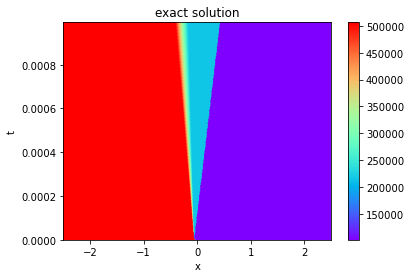

In [24]:
x_eval = np.ravel(X.T).reshape(-1, 1)
t_eval = np.ravel(T.T).reshape(-1, 1)

xmax = np.max(x_eval)
xmin = np.min(x_eval)
tmax = np.max(t_eval)

plt.figure()
plt.ylim(0, tmax)
plt.xlim(xmin, xmax)
plt.xlabel('x')
plt.ylabel('t')
plt.scatter(x_eval, t_eval, c=p_exact.T.reshape(-1, 1), vmin=np.min(p_exact), vmax=np.max(p_exact), cmap='rainbow')
plt.colorbar()
plt.title('exact solution')
plt.savefig("exact_sol_p.jpg")
plt.show()

In [67]:
p_exact.mean()

302417.45896508434

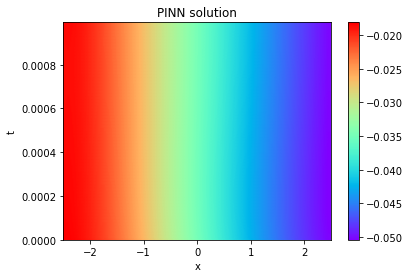

In [22]:
x_eval = np.ravel(X.T).reshape(-1, 1)
t_eval = np.ravel(T.T).reshape(-1, 1)

xmax = np.max(x_eval)
xmin = np.min(x_eval)
tmax = np.max(t_eval)

plt.figure()
plt.ylim(0, tmax)
plt.xlim(xmin, xmax)
plt.xlabel('x')
plt.ylabel('t')
plt.scatter(x_eval, t_eval, c=rho_pinn.reshape(-1, 1)*rho_max, cmap='rainbow')
plt.colorbar()
plt.title('PINN solution')
plt.savefig("pinn_sol_p_100000_200000.jpg")
plt.show()

In [15]:
p_pinn*p_max/p_exact.mean()

array([[1.00585039, 1.00585039, 1.00585039, ..., 1.00585039, 1.00585039,
        1.00585039],
       [1.00585039, 1.00585039, 1.00585039, ..., 1.00585039, 1.00585039,
        1.00585039],
       [1.00585039, 1.00585039, 1.00585039, ..., 1.00585039, 1.00585039,
        1.00585039],
       ...,
       [1.00585039, 1.00585039, 1.00585039, ..., 1.00585039, 1.00585039,
        1.00585039],
       [1.00585039, 1.00585039, 1.00585039, ..., 1.00585039, 1.00585039,
        1.00585039],
       [1.00585039, 1.00585039, 1.00585039, ..., 1.00585039, 1.00585039,
        1.00585039]])